In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Constants
EXPORT_PATH = "/home/student/suahmad/Richter_Final/Main_files/"
TARGET_COL = "Close_Price"
EXOG_VARS = ["GDP", "Unemployment_Rate", "Federal_Funds_Rate", "VIX"]
ORDER = (2, 1, 2)
SEASONAL_ORDER = (1, 1, 1, 4)
N_PREV_QUARTERS = 10
NUM_DATES = 4
SNP_PATH = "S&P500Data.csv"
TOP_N = 5                   # Now selecting top 5 stocks
INVEST_PER_STOCK = 10        # $10 invested per stock

In [ ]:
# Load and prepare S&P 500 data globally
SnP_raw = pd.read_csv(SNP_PATH, parse_dates=["DATE"])
SnP_raw = SnP_raw[["DATE", "Close_Price"]]
SnP_raw.set_index("DATE", inplace=True)
SnP_quarterly = SnP_raw["Close_Price"].resample("QE").last().ffill()

def load_and_prepare_data(filepath):
    """Read one ticker’s CSV, resample quarterly, merge exogenous + price."""
    df = pd.read_csv(filepath)
    df["DATE"] = pd.to_datetime(df["DATE"])
    df.set_index("DATE", inplace=True)
    exog_q = df[EXOG_VARS].resample("QE").mean()
    price_q = df[TARGET_COL].resample("QE").last()
    df_q = pd.concat([exog_q, price_q], axis=1)
    return df_q.ffill().dropna(subset=[TARGET_COL])

def predict_for_quarter(df_q, target_q_end):
    """
    Fit a SARIMAX on the prior N_PREV_QUARTERS to predict the one-step ahead,
    then compare forecast vs actual.
    """
    periods = df_q.index.to_period("Q")
    tgt = target_q_end.to_period("Q")
    if tgt not in periods:
        raise ValueError(f"Target quarter {tgt} not in data.")
    prev = tgt - 1
    start = prev - (N_PREV_QUARTERS - 1)
    window = pd.period_range(start=start, end=prev, freq="Q")
    train = df_q[periods.isin(window)]
    if len(train) < N_PREV_QUARTERS:
        raise ValueError("Insufficient data for training.")
    scaler = StandardScaler()
    exog_train = scaler.fit_transform(train[EXOG_VARS])
    test = df_q[periods == tgt]
    exog_test = scaler.transform(test[EXOG_VARS])

    model = SARIMAX(train[TARGET_COL],
                    exog=exog_train,
                    order=ORDER,
                    seasonal_order=SEASONAL_ORDER)
    res = model.fit(disp=False)
    forecast = res.forecast(steps=1, exog=exog_test).iloc[0]

    old_close = train[TARGET_COL].iloc[-1]
    new_close = test[TARGET_COL].iloc[0]

    pred_change = (forecast - old_close) / old_close
    act_change  = (new_close - old_close) / old_close

    return (
        forecast, new_close,
        pred_change, act_change,
        "Up" if pred_change > 0 else "Down",
        "Up" if act_change  > 0 else "Down",
        old_close
    )

def run_predictions_multiple_dates():
    # 1) Gather dates
    dates = []
    while len(dates) < NUM_DATES:
        try:
            d = pd.to_datetime(input(f"Enter date {len(dates)+1} (YYYY-MM-DD): "))
            dates.append(d)
        except Exception:
            print("❌ Invalid format. Try again.")

    quarter_ends = [d.to_period("Q").end_time for d in dates]

    # 2) Discover tickers
    tickers = [
        f.rsplit("_",1)[0]
        for f in os.listdir(EXPORT_PATH)
        if f.endswith("_combined.csv") and "_" in f
    ]
    scores = {t: {"correct":0, "total":0} for t in tickers}
    visual_data = []

    # 3) Loop through each quarter-end
    for qe in quarter_ends:
        print(f"\n📊 Prediction Results for {qe.date()}:\n")
        results = []

        for ticker in tickers:
            path = os.path.join(EXPORT_PATH, f"{ticker}_combined.csv")
            try:
                df_q = load_and_prepare_data(path)
                fc, nc, pc, ac, pd_dir, ad_dir, prev = predict_for_quarter(df_q, qe)
                results.append({
                    "Ticker": ticker,
                    "Previous_Close": prev,
                    "Predicted_Close": fc,
                    "Actual_Close":    nc,
                    "Predicted_Change_Rate": pc,
                    "Actual_Change_Rate":    ac,
                    "Predicted_Direction":   pd_dir,
                    "Actual_Direction":      ad_dir
                })
                scores[ticker]["total"] += 1
                if pd_dir == ad_dir:
                    scores[ticker]["correct"] += 1
            except Exception as e:
                print(f"⚠️ {ticker} on {qe.date()}: {e}")

        df_res = pd.DataFrame(results).sort_values("Predicted_Change_Rate", ascending=False)
        print("📈 Ranked by Predicted Change Rate:\n")
        print(df_res.to_string(index=False,
                               columns=["Ticker","Previous_Close","Predicted_Close",
                                        "Actual_Close","Predicted_Change_Rate",
                                        "Actual_Change_Rate","Predicted_Direction",
                                        "Actual_Direction"]))

        # 4) Investment comparison vs S&P500
        try:
            prev_q = ((qe.to_period("Q")-1).to_timestamp(how="end")).normalize()
            curr_q = qe.to_period("Q").to_timestamp(how="end").normalize()

            snp_old = SnP_quarterly.loc[prev_q]
            snp_new = SnP_quarterly.loc[curr_q]
            snp_ret = (snp_new - snp_old)/snp_old

            topn = df_res.head(TOP_N)
            if len(topn) == TOP_N:
                actual_vs = []
                for _, row in topn.iterrows():
                    df_q = load_and_prepare_data(
                        os.path.join(EXPORT_PATH, f"{row['Ticker']}_combined.csv")
                    )
                    pc_prev = df_q.loc[df_q.index.to_period("Q")==prev_q.to_period("Q"), TARGET_COL].iloc[-1]
                    pc_new  = df_q.loc[df_q.index.to_period("Q")==curr_q.to_period("Q"), TARGET_COL].iloc[-1]
                    r = (pc_new - pc_prev)/pc_prev
                    actual_vs.append(INVEST_PER_STOCK*(1+r))

                portfolio_val = sum(actual_vs)
                initial = INVEST_PER_STOCK * TOP_N
                snp_val = initial * (1 + snp_ret)

                visual_data.append({
                    "Quarter": qe.date(),
                    "S&P500":  snp_val,
                    f"Top{TOP_N}": portfolio_val
                })

                print(f"\n💼 Investment Comparison for {qe.date()}:")
                print(f"  - S&P500 Return: {snp_ret:.2%} → ${snp_val:.2f}")
                print(f"  - Top {TOP_N} Stocks → ${portfolio_val:.2f}")
                winner = "S&P500" if snp_val > portfolio_val else f"Top {TOP_N} Stocks"
                print(f"🔍 Better Performer: {winner}")
            else:
                print("⚠️ Not enough valid stocks for comparison.")
        except Exception as e:
            print(f"⚠️ Could not compute S&P500 comparison for {qe.date()}: {e}")

    # 5) Final accuracy summary
    summary = []
    for t, v in scores.items():
        tot = v["total"]
        cor = v["correct"]
        summary.append({
            "Ticker": t,
            "Correct": cor,
            "Total":   tot,
            "Accuracy": cor/tot if tot else np.nan
        })
    df_sum = pd.DataFrame(summary).sort_values("Accuracy", ascending=False)
    print("\n📊 Prediction Accuracy over all dates:\n")
    print(df_sum.to_string(index=False))

    # 6) Optional bar chart of visual_data
    if visual_data:
        dfv = pd.DataFrame(visual_data).set_index("Quarter")
        dfv.plot(kind="bar", figsize=(10,6))
        plt.title("Investment Comparison: S&P500 vs Top Stocks")
        plt.ylabel("Portfolio Value ($)")
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return df_sum

Enter date 1 (YYYY-MM-DD):  2021-01-01
Enter date 2 (YYYY-MM-DD):  2020-01-01
Enter date 3 (YYYY-MM-DD):  2019-01-01
Enter date 4 (YYYY-MM-DD):  2018-01-01



📊 Prediction Results for 2021-03-31:



/home/student/suahmad/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/student/suahmad/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/student/suahmad/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/student/suahmad/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to est

⚠️ ANTM on 2021-03-31: Target quarter 2021Q1 not in data.


/home/student/suahmad/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/student/suahmad/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/student/suahmad/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/student/suahmad/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to est

📈 Ranked by Predicted Change Rate:

Ticker  Previous_Close  Predicted_Close  Actual_Close  Predicted_Change_Rate  Actual_Change_Rate Predicted_Direction Actual_Direction
   DHR      193.571945       245.479664    196.321747               0.268157            0.014206                  Up               Up
  ISRG      272.700012       343.692833    246.313339               0.260333           -0.096761                  Up             Down
   TMO      460.939545       576.630388    451.898102               0.250989           -0.019615                  Up             Down
   ABT      100.930344       120.766257    110.916275               0.196531            0.098939                  Up               Up
   PFE       29.857288        35.215048     29.706524               0.179446           -0.005050                  Up             Down
   JNJ      139.603287       156.358296    146.695099               0.120019            0.050800                  Up               Up
  REGN      481.778198    

/home/student/suahmad/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/student/suahmad/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/student/suahmad/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/student/suahmad/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to est

⚠️ ANTM on 2020-03-31: Target quarter 2020Q1 not in data.


/home/student/suahmad/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/student/suahmad/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/student/suahmad/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/student/suahmad/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization 

📈 Ranked by Predicted Change Rate:

Ticker  Previous_Close  Predicted_Close  Actual_Close  Predicted_Change_Rate  Actual_Change_Rate Predicted_Direction Actual_Direction
  REGN      374.444916       542.575787    486.943939               0.449014            0.300442                  Up               Up
   MRK       73.827469       103.885406     62.970974               0.407138           -0.147052                  Up             Down
   BMY       52.646233        72.120470     46.038605               0.369908           -0.125510                  Up             Down
  GILD       52.608246        71.202398     61.089844               0.353446            0.161222                  Up               Up
  AMGN      203.480667       271.474257    172.333603               0.334153           -0.153071                  Up             Down
   CVS       62.407429        80.125144     50.176609               0.283904           -0.195983                  Up             Down
   PFE       28.968105    

/home/student/suahmad/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/student/suahmad/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/student/suahmad/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/student/suahmad/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to est

⚠️ ANTM on 2019-03-31: Target quarter 2019Q1 not in data.


/home/student/suahmad/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/student/suahmad/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/student/suahmad/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/student/suahmad/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization 

📈 Ranked by Predicted Change Rate:

Ticker  Previous_Close  Predicted_Close  Actual_Close  Predicted_Change_Rate  Actual_Change_Rate Predicted_Direction Actual_Direction
  ABBV       69.119408        91.499543     61.163403               0.323789           -0.115105                  Up             Down
  VRTX      165.710007       204.984133    183.949997               0.237005            0.110072                  Up               Up
   BMY       41.214203        46.013943     38.126724               0.116458           -0.074913                  Up             Down
  GILD       48.765232        52.955929     51.173428               0.085936            0.049383                  Up               Up
   UNH      226.650742       228.015967    225.817169               0.006023           -0.003678                  Up             Down
  AMGN      159.466263       156.927161    156.827667              -0.015923           -0.016546                Down             Down
    CI      176.372940    

/home/student/suahmad/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/student/suahmad/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/student/suahmad/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/student/suahmad/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to est

⚠️ ANTM on 2018-03-31: Target quarter 2018Q1 not in data.


/home/student/suahmad/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/student/suahmad/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/student/suahmad/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/student/suahmad/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization 

📈 Ranked by Predicted Change Rate:

Ticker  Previous_Close  Predicted_Close  Actual_Close  Predicted_Change_Rate  Actual_Change_Rate Predicted_Direction Actual_Direction
   UNH      197.906860       228.158407    192.743790               0.152857           -0.026088                  Up             Down
    KO       36.543026        38.653832     34.896965               0.057762           -0.045044                  Up             Down
   BMY       47.315918        48.872717     49.157467               0.032902            0.038920                  Up               Up
  ISRG      121.646667       125.206283    137.610001               0.029262            0.131227                  Up               Up
  ABBV       69.786919        71.584157     68.790321               0.025753           -0.014281                  Up             Down
   CVS       57.249607        57.688642     49.429436               0.007669           -0.136598                  Up             Down
   JNJ      114.250969    

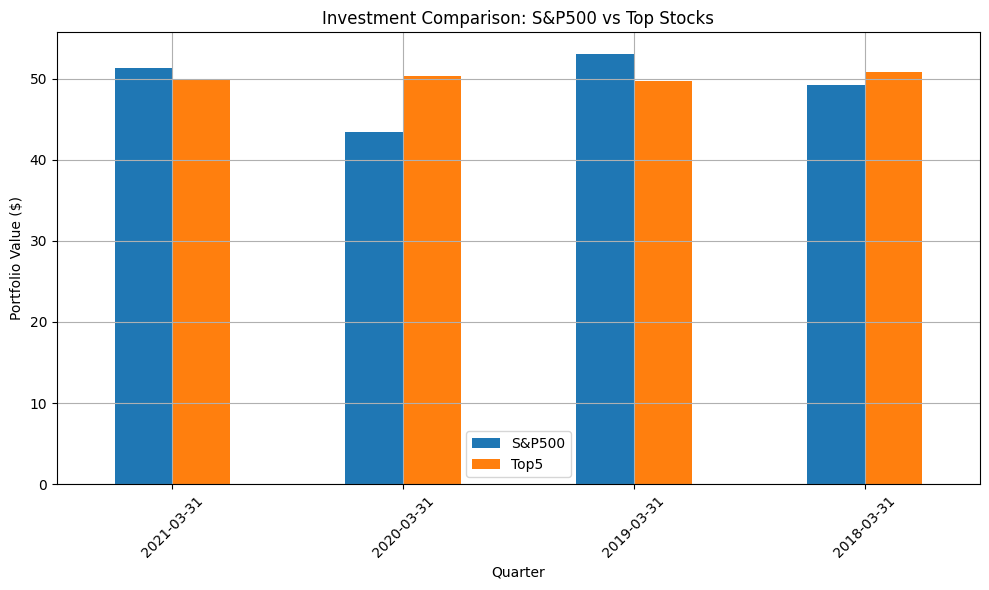

In [ ]:
if __name__ == "__main__":
    run_predictions_multiple_dates()